##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the \"License\");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

### Image Super Resolution using ESRGAN
TensorFlow implementation of Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)].

Model trained on DIV2K Dataset on image patches of size 128 x 128

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

**Preparing Environment**

In [0]:
import os
import time
from PIL import Image
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
tf.enable_v2_behavior()
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
!wget "https://images.wallpaperscraft.com/image/landscape_grass_river_96482_1280x720.jpg" -O original.jpg

--2019-08-17 09:46:35--  https://images.wallpaperscraft.com/image/landscape_grass_river_96482_1280x720.jpg
Resolving images.wallpaperscraft.com (images.wallpaperscraft.com)... 159.69.116.38, 159.69.181.111, 195.201.24.173, ...
Connecting to images.wallpaperscraft.com (images.wallpaperscraft.com)|159.69.116.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 705469 (689K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>] 688.93K  1.19MB/s    in 0.6s    

2019-08-17 09:46:41 (1.19 MB/s) - ‘original.jpg’ saved [705469/705469]



In [0]:
# Declaring Constants
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz"

In [0]:
def preprocess_image(image_path):
  """
      Loads image from path and scales down using bicubic downsampling.
      Args:
          image_path: Path to the image file.
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  _can_calculate_psnr = False
  if hr_image.shape[0] >= 720 and hr_image.shape[1] >= 1080:
      hr_image = tf.image.random_crop(hr_image, [720, 1080, 3])
      _can_calculate_psnr = True
  lr_image = tf.expand_dims(tf.image.resize(hr_image, [720 // 4, 1080 // 4], method="bicubic"), 0)
  hr_image = tf.cast(hr_image, tf.float32)
  return lr_image, hr_image, _can_calculate_psnr

In [0]:
% matplotlib inline
def plot_image(image, title="", save=False):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = Image.fromarray(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8).numpy())
  if save:
    image.save("%s.jpg" % title)
    print("Saved Image to: %s.jpg" % title)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)
  plt.show()

In [0]:
lr_image, hr_image, _can_calculate_psnr = preprocess_image(IMAGE_PATH)

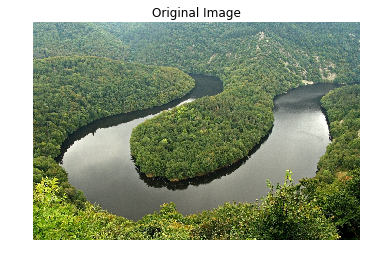

In [8]:
# Plotting Original Resolution image
plot_image(hr_image, title="Original Image")

In [9]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz, Total size: 5.70MB



In [10]:
start = time.time()
fake_image = model.call(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 4.098414


Saved Image to: Low Resolution.jpg


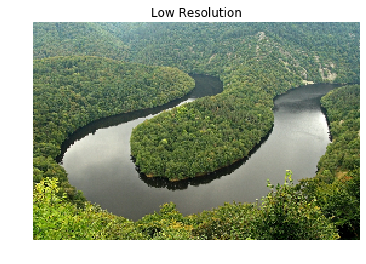

In [11]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), "Low Resolution", save=True)

Saved Image to: Super Resolution.jpg


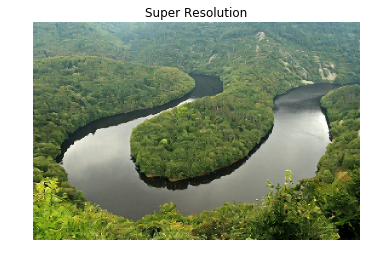

PSNR Achieved: 22.503069


In [12]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), "Super Resolution", save=True)
# Calculating PSNR wrt Original Image
if _can_calculate_psnr:
  print("PSNR Achieved: %f" % tf.image.psnr(
      tf.clip_by_value(fake_image, 0, 255),
      tf.clip_by_value(hr_image, 0, 255), max_val=255))